In [347]:
!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=vertevniku&password=Password!123&submit=Login' https://www.cityscapes-dataset.com/login/
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-04-09 19:05:02--  https://www.cityscapes-dataset.com/login/
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cityscapes-dataset.com/downloads/ [following]
--2024-04-09 19:05:03--  https://www.cityscapes-dataset.com/downloads/
Reusing existing connection to www.cityscapes-dataset.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: 'index.html'

index.html              [   <=>              ]  57.34K   142KB/s    in 0.4s    

2024-04-09 19:05:04 (142 KB/s) - 'index.html' saved [58715]

--2024-04-09 19:05:05--  https://www.cityscapes-dataset.com/file-handling/?packageID=1
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8

In [348]:
!unzip gtFine_trainvaltest.zip > /dev/null
!unzip -o /content/leftImg8bit_trainvaltest.zip > /dev/null

unzip:  cannot find or open /content/leftImg8bit_trainvaltest.zip, /content/leftImg8bit_trainvaltest.zip.zip or /content/leftImg8bit_trainvaltest.zip.ZIP.


# Config

In [1]:
from dataclasses import dataclass, field
from typing import Dict, List, Tuple
import torch


@dataclass
class CFG:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    n_epochs: int = 10
    batch_size: int = 16
    dataset: str = 'cityscapes'
    data_path: str = '/kaggle/input/cityscapes-image-pairs/cityscapes_data'  # TODO
    semantic_classes: int = 19
    c_hidden: int = 64

    loss_coefs: Dict = field(default_factory=lambda: {
        'mma_G': 1,
        'mma_D': 1,
        'pix_contr': 1,
        'L1': 1,
        'sim': 1,
        'perc': 10,
        'discr_f': 10
    })

    lr = 0.0001
    beta1 = 0.
    beta2 = 0.999

    project_name = 'ECGAN'

    kernel_size = 3
    padding = 1

    LG_model_name = "nvidia/segformer-b0-finetuned-cityscapes-768-768"

    cityscapes_classes = [
        "road",
        "sidewalk",
        "building",
        "wall",
        "fence",
        "pole",
        "traffic light",
        "traffic sign",
        "vegetation",
        "terrain",
        "sky",
        "person",
        "rider",
        "car",
        "truck",
        "bus",
        "train",
        "motorcycle",
        "bicycle",
    ]

    cityscapes_palette = [
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [70, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

# Dataset

In [315]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms


class CityScapesDataSet(Dataset):
    def __init__(self, src_data: str, train=True):
        self.path = src_data
        self.path += '/train/' if train else '/val/'
        self.length = 2975 if train else 500
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(0.5, 0.5)])

    def __len__(self):
        return self.length

    def __getitem__(self, item: int):
        img = transforms.functional.pil_to_tensor(Image.open(self.path + str(item + 1) +'.jpg'))
        return (img[:,:,:256] / 255 - 0.5) * 2, img[:,:,256:]

# utils

In [3]:
import torch
from torch import nn
import cv2 as cv
import numpy as np
import torchvision.transforms as T


def toRGB(x):
    return ((x + 1) / 2 * 255).to(torch.uint8)

# def RGB2n(x, colors):  #x: batch x 3 x h x w, colors: 35 x 3
#     x1 = x.repeat(colors.shape[0], 1, 1, 1, 1).permute(1, 3, 4, 0, 2).int()  # B x h x w x 35 x 3
#     return torch.all(x1 == colors, dim=-1).permute(0, 3, 1, 2).float()  # B x 35 x H x W
def RGB2n(x, colors):  #x: batch x 3 x h x w, colors: 19 x 3
    x1 = x.permute(0, 2, 3, 1) # batch x H x W x 3
    x1 = x1.unsqueeze(1) # batch x 1 x H x W x 3
    x1 = x1.repeat(1, colors.shape[0], 1, 1, 1) # batch x 19 x H x W x 3
    
    colors1 = colors.unsqueeze(1).unsqueeze(1) # 19 x 1 x 1 x 3
    colors1 = colors1.repeat(1, x.shape[-2], x.shape[-1], 1) # 19 x H x W x 3
    
    res = x1 == colors1 # batch x 19 x H x W x 3
    return torch.all(res, dim=-1).int()


class Canny(nn.Module):
    def __init__(self, t_low=100, t_high=200):
        super().__init__()
        self.t_low = t_low
        self.t_high = t_high

    @torch.no_grad()
    def forward(self, x):
        """
        x: (B, C, H, W) in (-1, 1)
        """
        device = x.device
        B, C, H, W = x.shape
        img = x.permute((0, 2, 3, 1))
        img = toRGB(img).detach().cpu().numpy()
        img = img.reshape(B * H, W, C)
        edges = cv.Canny(img, self.t_low, self.t_high)
        edges = torch.tensor(edges.reshape(B, H, W)).unsqueeze(1)
        edges = edges.repeat(1, 3, 1, 1).to(device).float()/255
        return T.Normalize(0.5, 0.5)(edges)


# Network

In [4]:
import torch
import numpy as np
from torch import nn
from torch.nn.utils import spectral_norm
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation


class ResBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()

        self.conv1 = nn.Conv2d(channels_in, channels_out, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels_out)

        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels_out)

        self.relu = nn.ReLU()

        self.projection = nn.Sequential(
            nn.Conv2d(channels_in, channels_out, 1)
        )


    def forward(self, x):
        x_in = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = self.projection(x_in) + x
        x = self.relu(x)
        return x


class Encoder(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()

        self.net = nn.Sequential(
            ResBlock(channels_in, channels_out // 8),
            ResBlock(channels_out // 8, channels_out // 4),
            ResBlock(channels_out // 4, channels_out // 2),
            ResBlock(channels_out // 2, channels_out),
        )

    def forward(self, x):
        return self.net(x)


class ConvBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv = spectral_norm(nn.Conv2d(channels_in, channels_out, 3, padding=1))

    def forward(self, x):
        x = self.conv(x)
        return x


class Generator(nn.Module):
    def __init__(self, channels_in, c_hidden, channels_out, n=3):
        super().__init__()
        self.n = n

        self.encoder = Encoder(channels_in, c_hidden)

        convs_edge = []
        convs_img = []

        for _ in range(n):
            convs_edge.append(ConvBlock(c_hidden, c_hidden // 2))
            convs_img.append(ConvBlock(c_hidden, c_hidden // 2))
            c_hidden //= 2

        self.convs_edge = nn.ModuleList(convs_edge)
        self.convs_img = nn.ModuleList(convs_img)

        self.edge_final = nn.Sequential(
            ConvBlock(c_hidden, channels_out),
            nn.Tanh()
        )

        self.img_final = nn.Sequential(
            ConvBlock(c_hidden, channels_out),
            nn.Tanh()
        )

        self.sigmoid = nn.Sigmoid()

        self.canny = Canny()

    def forward(self, x):
        x_in = x

        f = self.encoder(x)

        out_edge = f
        out_img = f

        for conv_e, conv_i in zip(self.convs_edge, self.convs_img):
            out_edge = conv_e(out_edge)
            out_img = conv_i(out_img)
#             out_img += self.sigmoid(out_edge) * out_img
            out_img = out_img + self.sigmoid(out_edge) * out_img

        out_edge = self.edge_final(out_edge)
        out_edge = self.canny(out_edge)  # TODO

        out_img = self.img_final(out_img)
#         out_img += self.sigmoid(out_edge) * out_img
        out_img = out_img + self.sigmoid(out_edge) * out_img

        return f, out_edge, out_img


class SemanticPreserveModule(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.conv1 = spectral_norm(nn.Conv2d(in_channels=config.c_hidden + config.semantic_classes + 6,
                                             out_channels=config.semantic_classes,
                                             kernel_size=config.kernel_size, padding=config.padding))
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.sigmoid = nn.Sigmoid()
        self.conv2 = spectral_norm(nn.Conv2d(in_channels=config.semantic_classes,
                                             out_channels=config.c_hidden + config.semantic_classes + 6,
                                             kernel_size=config.kernel_size, padding=config.padding))

        self.final = spectral_norm(nn.Conv2d(in_channels=config.c_hidden + config.semantic_classes + 6,
                                             out_channels=3,
                                             kernel_size=config.kernel_size, padding=config.padding))
        self.tanh = nn.Tanh()

    def forward(self, x):
        identity = self.conv1(x)

        out = self.avg_pool(identity)
        out = self.sigmoid(self.avg_pool(out))
        out = out * identity + identity

        out = self.conv2(out)

        out = self.tanh(self.final(out))
        return out


class Discriminator(nn.Module):
    def __init__(self, config):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2),  # 256 -> 128
            self._downsample_block(3 + 19, 64),  # 128 -> 64
            self._downsample_block(64, 128),  # 64 -> 32
            self._downsample_block(128, 256),  # 32 -> 16
            self._downsample_block(256, 512),  # 16 -> 8
            nn.Conv2d(512, 64, kernel_size=1)
        )

        self.fc = nn.Sequential(
            spectral_norm(nn.Linear(64 * 8 * 8, 128)),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1))

    def _downsample_block(self, input_channels, output_channels):
        return nn.Sequential(
            spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, stride=2)),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2, inplace=True))

    def forward(self, x, y):  #x: B x 3 x H x W, y: B x 19 x H x W
        x1 = torch.concat([x, y], dim=1)  # B x C + N x H x W
        x1 = self.layers(x1).reshape(x1.shape[0], -1)
        x1 = self.fc(x1)
        return x1


class LabelGenerator(nn.Module):
    def __init__(self, config):
        super(LabelGenerator, self).__init__()

        self.processor = SegformerImageProcessor(do_resize=False)
        self.model = SegformerForSemanticSegmentation.from_pretrained(config.LG_model_name)
        self.device = config.device
        self.palette = config.cityscapes_palette
        self.model.to(self.device)

    def forward(self, imgs):
        pixel_values = self.processor(toRGB(imgs), return_tensors="pt").pixel_values.to(self.device)

        with torch.no_grad():
            outputs = self.model(pixel_values)

        predicted_segmentation_maps = self.processor.post_process_semantic_segmentation(outputs,
                                                                                        target_sizes=[imgs.shape[2:] for
                                                                                                      _ in range(
                                                                                                imgs.shape[0])])
        predicted_segmentation_maps = torch.stack(predicted_segmentation_maps, dim=0).cpu().numpy()  # B x H x W

        color_segs = np.zeros((predicted_segmentation_maps.shape[0],
                               predicted_segmentation_maps.shape[1],
                               predicted_segmentation_maps.shape[2], 3), dtype=np.uint8)  # B x H x W x 3

        palette = np.array(self.palette)
        for label, color in enumerate(palette):
            color_segs[predicted_segmentation_maps == label, :] = color

        color_segs = torch.tensor(color_segs).permute(0, 3, 1, 2).to(self.device)  # B x 3 x H x W

        return color_segs  # RGB non-normalized



class ECGAN(nn.Module):
    def __init__(self, config, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = Generator(config.semantic_classes, config.c_hidden, 3)
        self.discriminator = Discriminator(config)
        self.semantic_preserving_module = SemanticPreserveModule(config)
        self.label_generator = LabelGenerator(config)
        self.canny = Canny()


    def forward(self, s):
        f, out_edge, out_img1 = self.generator(s)

        out_img2 = self.semantic_preserving_module(torch.cat([s, f, out_edge, out_img1], dim=1))
        
        with torch.no_grad():
            labels = self.label_generator(out_img2)

        return f, out_edge, out_img1, out_img2, labels


2024-04-09 17:07:26.801757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 17:07:26.802000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 17:07:26.963206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# model = ECGAN(CFG)
# num_parameters = 0

# for param in model.parameters():
#     num_parameters += param.numel()

# print(f'The model has {num_parameters} parameters.')

# Loss

In [19]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision

def pixel_contrastive_loss(img_seg, f, labels):
    '''
    :param img_seg: (B, 3, H, W)
    :param f: (B, C, H, W)
    :param labels:
    :return:
    '''

    total_loss = 0

    img_seg = torch.permute(
        img_seg, (0, 2, 3, 1)).flatten(end_dim=-2)  # (-1 , 3)
    f = torch.permute(f, (0, 2, 3, 1)).flatten(end_dim=-2)  # (-1 , C)

    for label in labels:
        mask = torch.all(img_seg == label, dim=-1)
        if mask.sum() == 0:
            continue

        pos = np.random.choice(len(f[mask]), min(
            10000, len(f[mask])), replace=False)
        neg = np.random.choice(len(f[~mask]), min(
            10000, len(f[~mask])), replace=False)

        pos_batch = f[mask][pos] / \
                    (f[mask][pos] ** 2).sum(dim=1).sqrt().reshape(-1, 1)
        neg_batch = f[~mask][neg] / \
                    (f[~mask][neg] ** 2).sum(dim=1).sqrt().reshape(-1, 1)

        loss = torch.exp(pos_batch @ pos_batch.T)
        sum_neg = torch.exp(pos_batch @ neg_batch.T).sum(dim=1)
        loss = -torch.log(loss / (loss + sum_neg)).sum() / \
               mask.sum() / pos_batch.size(0)
        total_loss += loss

    return total_loss


def reconstructive_loss(img_true, img_pred):
    '''
    :param img_true: (B, 3, H, W)
    :param img_pred: (B, 3, H, W)
    :return:
    '''

    return abs(img_true - img_pred).sum()


def generator_mma_loss(edge_fake_logits, img_fake1_logits, img_fake2_logits, lmbd=2):
    edge_fake_loss = F.binary_cross_entropy_with_logits(edge_fake_logits, torch.ones_like(edge_fake_logits))
    img_fake_loss1 = F.binary_cross_entropy_with_logits(img_fake1_logits, torch.ones_like(img_fake1_logits))
    img_fake_loss2 = F.binary_cross_entropy_with_logits(img_fake2_logits, torch.ones_like(img_fake2_logits))
    return lmbd * img_fake_loss2 + img_fake_loss1 + edge_fake_loss


def discr_mma_loss(edge_real_logits, img_real_logits, edge_fake_logits, img_fake1_logits, img_fake2_logits, lmbd=2):
    edge_real_loss = F.binary_cross_entropy_with_logits(edge_real_logits, torch.ones_like(edge_real_logits))
    edge_fake_loss = F.binary_cross_entropy_with_logits(edge_fake_logits.detach(), torch.zeros_like(edge_fake_logits))

    img_real_loss = F.binary_cross_entropy_with_logits(img_real_logits, torch.ones_like(img_real_logits))
    img_fake_loss1 = F.binary_cross_entropy_with_logits(img_fake1_logits.detach(), torch.zeros_like(img_fake1_logits))
    img_fake_loss2 = F.binary_cross_entropy_with_logits(img_fake2_logits.detach(), torch.zeros_like(img_fake2_logits))

    return (lmbd + 1) * img_real_loss + lmbd * img_fake_loss2 + img_fake_loss1 + \
        edge_real_loss + edge_fake_loss


# https://gist.github.com/alper111/8233cdb0414b4cb5853f2f730ab95a49
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)

    def forward(self, input, target):
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y)
        return loss


def similarity_loss(x, y):  # N x H x W
    x1 = x.reshape(x.shape[0], -1)  # N x M     M = HW
    x_s = x1 @ x1.T  # M x M

    y1 = y.reshape(y.shape[0], -1)
    y_s = y1 @ y1.T

    m = x_s.shape[0]

    return -1 / (m * m) * (y_s * x_s.log() + (1 - y_s) * (1 - x_s).log()).sum()


def disc_feature_loss(x, y):
    return F.l1_loss(x, y)


class GANLossFactory:
    def __init__(self, config):
        self.perc = VGGPerceptualLoss().to(config.device)
        self._coefs = config.loss_coefs
        self._losses = {
            'mma_G': generator_mma_loss,
            'mma_D': discr_mma_loss,
            'pix_contr': pixel_contrastive_loss,
            'L1': reconstructive_loss,
            'sim': similarity_loss,
            'perc': self.perc,
            'discr_f': disc_feature_loss,
        }

    def __getitem__(self, key):
        return lambda *args, **kwargs: self._coefs[key] * self._losses[key](*args, **kwargs)


# Train

In [20]:
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import wandb


class Trainer:
    def __init__(self, config):
        self.config = config

        self.device = self.config.device
        self.model = ECGAN(self.config).to(self.device)
        self.optimizers = {
            'G': torch.optim.Adam(self.model.generator.parameters(), lr=self.config.lr,
                                  betas=(self.config.beta1, self.config.beta2)),
            'D': torch.optim.Adam(self.model.discriminator.parameters(), lr=self.config.lr,
                                  betas=(self.config.beta1, self.config.beta2)),
        }

        dataset = CityScapesDataSet(self.config.data_path, train=True)
        self.loader = DataLoader(dataset, batch_size=self.config.batch_size,
                                 shuffle=True, num_workers=0)

        self.losses = GANLossFactory(self.config)
        self.labels = torch.tensor(config.cityscapes_palette, device=self.device)
        self.epoch = 0
        
        self.log_batch = next(iter(self.loader))

        wandb.init(project=config.project_name)

    def train_epoch(self):
        self.model.train()
        total_loss_D, total_loss_G = 0, 0
        for img, img_seg in tqdm(self.loader, desc='Training'):
            img = img.to(self.device)
            img_seg = img_seg.to(self.device)

            s = RGB2n(toRGB(img_seg), self.labels)
            
            loss_D = self.update_D(img, s)
            loss_G = self.update_G(img, img_seg, s)
            
            total_loss_D += loss_D
            total_loss_G = loss_G
            
            break

        self.wandb_log_img()
#         self.wandb_log_losses(total_loss_D/len(self.loader), total_loss_G/len(self.loader))

        self.wandb_log_losses(total_loss_D, total_loss_G)

    
    @torch.no_grad()
    def wandb_log_img(self):
        imgs, segs = self.log_batch
        s = RGB2n(toRGB(segs.to(self.device)), self.labels)
        
        self.model.eval()
        f, out_edge, out_img1, out_img2, pred_labels = self.model(s)
        
        res = torch.cat([toRGB(imgs.to(self.device)), 
                         toRGB(segs.to(self.device)), 
                         toRGB(out_img2), toRGB(out_img1), toRGB(out_edge)], dim=-2)
    
        res = [wandb.Image(to_pil_image(res[i])) for i in range(4)]
        
        wandb.log({"res": res})
    
    @torch.no_grad()
    def wandb_log_losses(self, loss_D, loss_G):
        wandb.log({'loss_D' : loss_D, 'loss_G' : loss_G})


    def update_D(self, img, s):
        self.optimizers['D'].zero_grad()

        img_edge = self.model.canny(img)
        f, out_edge, out_img1, out_img2, pred_labels = self.model(s)

        edge_real_logits = self.model.discriminator(img_edge, s)
        edge_fake_logits = self.model.discriminator(out_edge, s)
        img_real_logits = self.model.discriminator(img, s)
        img_fake1_logits = self.model.discriminator(out_img1, s)
        img_fake2_logits = self.model.discriminator(out_img2, s)

        loss = self.losses['mma_D'](edge_real_logits, img_real_logits, edge_fake_logits, img_fake1_logits,
                                    img_fake2_logits)
        loss.backward()

        self.optimizers['D'].step()
        
        return loss

    def update_G(self, img, img_seg, s):
        self.optimizers['G'].zero_grad()
        f, out_edge, out_img1, out_img2, pred_labels = self.model(s)
        s_fake = RGB2n(pred_labels, self.labels)
        img_edge = self.model.canny(img)

        edge_real_logits = self.model.discriminator(img_edge, s).detach()
        edge_fake_logits = self.model.discriminator(out_edge, s)
        img_real_logits = self.model.discriminator(img, s).detach()
        img_fake1_logits = self.model.discriminator(out_img1, s)
        img_fake2_logits = self.model.discriminator(out_img2, s)

        loss_dict = {
            'mma_G': self.losses['mma_G'](edge_fake_logits, img_fake1_logits, img_fake2_logits),
            'pix_contr': self.losses['pix_contr'](toRGB(img_seg), f, self.labels),
            'L1': self.losses['L1'](img, out_img1),
            'sim': self.losses['sim'](s_fake, s),
            'perc_edge': self.losses['perc'](img_edge.float(), out_edge.float()),
            'perc_img1': self.losses['perc'](img, out_img1),
            'perc_img2': self.losses['perc'](img, out_img2),
            'discr_f_edge': self.losses['discr_f'](edge_real_logits, edge_fake_logits),
            'discr_f_img1': self.losses['discr_f'](img_real_logits, img_fake1_logits),
            'discr_f_img2': self.losses['discr_f'](img_real_logits, img_fake2_logits)
        }
        
        loss = sum(loss_dict.values())

        loss.backward()

        self.optimizers['G'].step()
        
        return loss_dict

    def train(self):
        for self.epoch in range(1, self.config.n_epochs + 1):
            self.train_epoch()


# Inference

In [21]:
# config = CFG()
# trainer = Trainer(config)
# trainer.train()

In [316]:
train_set = CityScapesDataSet('/kaggle/input/cityscapes-image-pairs/cityscapes_data')
val_set = CityScapesDataSet('/kaggle/input/cityscapes-image-pairs/cityscapes_data', train=False)

train_loader = DataLoader(train_set, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=CFG.batch_size, shuffle=False)

In [317]:
batch = next(iter(train_loader))

In [319]:
model = ECGAN(CFG)

In [343]:
labels = torch.tensor(CFG.cityscapes_palette)
img, img_seg = batch

s = RGB2n(img_seg, labels).float()

f, out_edge, out_img1, out_img2, pred_labels = model(s)

In [322]:
s.shape

torch.Size([16, 19, 256, 256])

In [50]:
def similarity_loss(x, y):  #B x N x H x W
    x1 = x.reshape(x.shape[0], x.shape[1], -1)  # B x N x M     M = HW
    x_s = x1 @ x1.permute(0, 2, 1)  # M x M
    
    y1 = y.reshape(y.shape[0], y.shape[1], -1)
    y_s = y1 @ y1.permute(0, 2, 1)

    print(x_s.sum())
    m = x_s.shape[0]

    return -1 / (m * m) * (y_s * x_s.log() + (1 - y_s) * (1 - x_s).log()).sum()

In [51]:
similarity_loss(RGB2n(pred_labels, labels), s)

tensor(1048576.)


tensor(nan)

In [336]:
def RGB2n(x, colors):  #x: batch x 3 x h x w, colors: 19 x 3
    x1 = x.permute(0, 2, 3, 1) # batch x H x W x 3
    x1 = x1.unsqueeze(1) # batch x 1 x H x W x 3
    x1 = x1.repeat(1, colors.shape[0], 1, 1, 1) # batch x 19 x H x W x 3
    
    colors1 = colors.unsqueeze(1).unsqueeze(1) # 19 x 1 x 1 x 3
    colors1 = colors1.repeat(1, x.shape[-2], x.shape[-1], 1) # 19 x H x W x 3
    
    res = x1 == colors1 # batch x 19 x H x W x 3
    return torch.all(res, dim=-1).int()

In [337]:
RGB2n(toRGB(img_seg), labels)[0].sum(), toRGB(img_seg).shape[-1]**2

(tensor(0), 65536)

In [346]:
img_seg[0].permute(1, 2, 0)

tensor([[[ 8,  7,  2],
         [ 0,  0,  0],
         [ 6,  6,  6],
         ...,
         [ 0,  0,  0],
         [ 1,  1,  1],
         [ 7,  7,  7]],

        [[ 1,  0,  0],
         [ 2,  2,  2],
         [33, 33, 33],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 2,  2,  2]],

        [[ 1,  0,  0],
         [ 5,  5,  5],
         [53, 53, 53],
         ...,
         [ 2,  2,  2],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        ...,

        [[ 0,  1,  0],
         [ 0,  0,  0],
         [ 0,  0,  2],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  3,  0],
         [ 0,  2,  0],
         [ 0,  2,  1],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  3,  0],
         [ 0,  2,  0],
         [ 0,  2,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]]], dtype=torch.uint8)

In [342]:
torch.unique(img_seg[0].permute(1, 2, 0).reshape(256*256, 3), dim=0)

tensor([[  0,   0,   0],
        [  0,   0,   2],
        [  0,   0,   4],
        ...,
        [255,  32, 245],
        [255,  33, 242],
        [255,  37, 245]], dtype=torch.uint8)

In [325]:
torch.all(toRGB(img_seg)[0].permute(1, 2, 0).reshape(256*256, 3) == torch.tensor([0, 0, 0]), dim=-1).sum()

tensor(0)

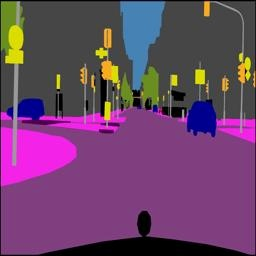

In [310]:
to_pil_image(toRGB(img_seg[0]))

In [287]:
torch.unique(toRGB(img_seg)[0].permute(1, 2, 0), dim=-1)

tensor([[[  0,   0,   6],
         [  3,   8,  21],
         [  0,   0,   9],
         ...,
         [  0,   0,   0],
         [ 16,  16,  16],
         [  0,   0,   0]],

        [[ 19,  27,  39],
         [ 65,  79,  94],
         [ 53,  79,  96],
         ...,
         [ 47,  47,  47],
         [ 54,  54,  54],
         [ 24,  24,  24]],

        [[  1,  22,  38],
         [ 76, 109, 129],
         [ 75, 118, 140],
         ...,
         [ 77,  77,  77],
         [ 73,  73,  73],
         [ 31,  31,  31]],

        ...,

        [[ 37,  39,  15],
         [102, 105,  70],
         [107, 110,  73],
         ...,
         [117, 116,  75],
         [113, 115,  73],
         [ 58,  59,  18]],

        [[ 39,  40,  23],
         [ 77,  82,  53],
         [ 77,  81,  50],
         ...,
         [ 81,  82,  47],
         [ 82,  84,  48],
         [ 39,  40,   6]],

        [[  8,   9,   0],
         [ 25,  28,   5],
         [ 15,  18,   0],
         ...,
         [ 20,  20,   0],
        

In [272]:
def RGB2n(img_seg, labels):
    """
    img_seg: Bx3xHxW
    labels: 19x3
    """
    x = img_seg.permute(0,2,3,1) #BxHxWx3
    res = x.unsqueeze(-2).repeat(1,1,1,labels.size(0),1) == labels #BxHxWx19x3
    return torch.all(res, dim=-1).permute(3,1,2,0).int()

(tensor(112217), 1048576)

In [237]:
x = torch.tensor([[[1, 1], [1, 1]], # H x W x 2
                  [[2, 2], [3, 1]]])
x1 = x.repeat(3, 1, 1, 1) # 3 x H x W x 2

colors = torch.tensor([[1, 1], [2, 2], [3, 1]]) # 3 x 2
colors1 = colors.unsqueeze(1).unsqueeze(1).repeat(1, 2, 2, 1) # 3 x H x W x 2
# torch.all(x == colors, dim=)

In [238]:
torch.all(x1 == colors1, dim=-1).sum()

tensor(4)

In [167]:
x1 == colors1

tensor([[[ True,  True],
         [False, False]],

        [[False, False],
         [ True, False]],

        [[False, False],
         [False,  True]]])

# 

In [133]:
# import wandb

# wandb.login()

In [22]:
wandb.init(project='smth')

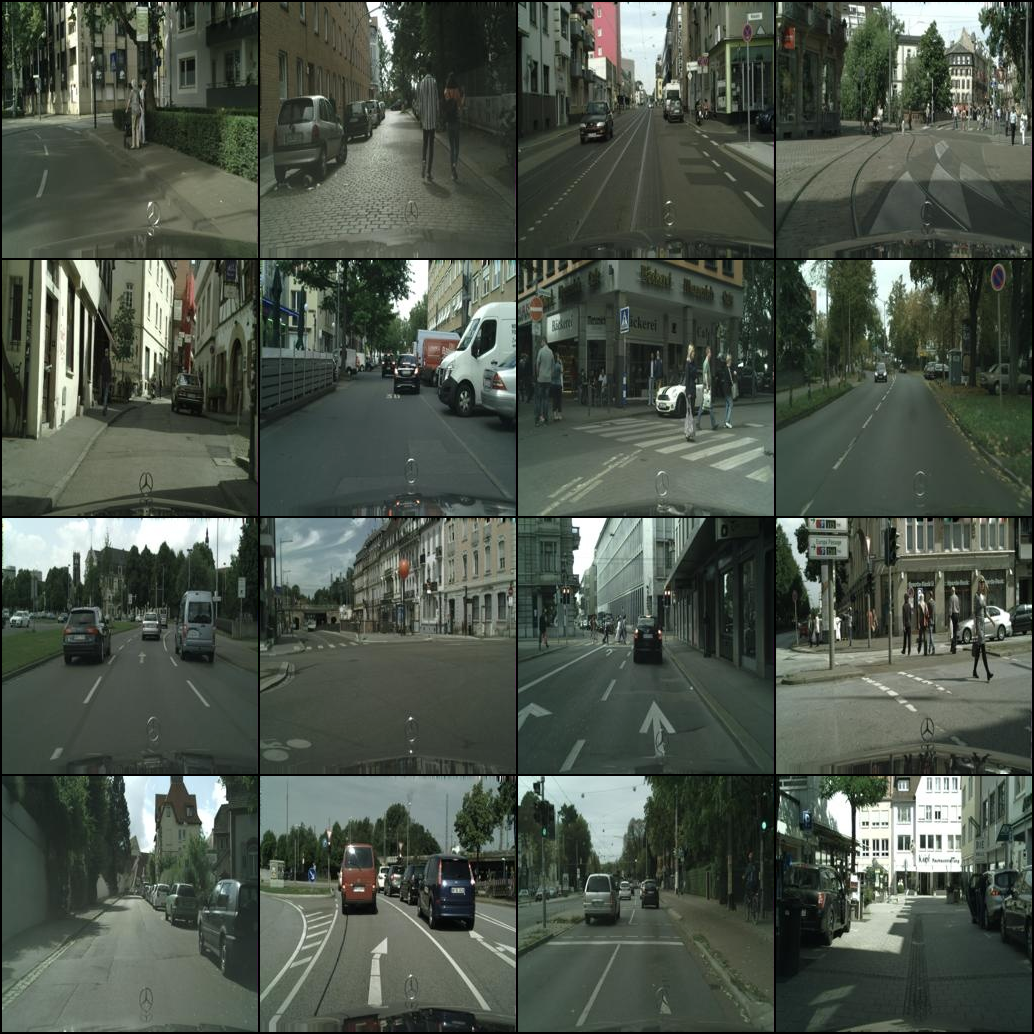

In [33]:
to_pil_image(make_grid(toRGB(imgs), nrow=4))

In [74]:
wandb.init(project='smth')

In [84]:
imgs, segs = next(iter(train_loader))

imgs1 = toRGB(imgs)//2 + toRGB(segs)//2
imgs2 = torch.cat([imgs1, imgs1], dim=-2)

images = [wandb.Image(to_pil_image(imgs2[i])) for i in range(8)]

# images1 = torch.cat([images, images], dim=-2)

wandb.log({"examples": images})

# mask_data = 

# class_labels = {1: "tree", 2: "car", 3: "road"}

# mask_img = wandb.Image(
#     image,
#     masks={
#         "predictions": {"mask_data": mask_data, "class_labels": class_labels},
#         "ground_truth": {
#             # ...
#         },
#         # ...
#     },
# )

In [79]:
torch.cat([torch.tensor([[1, 2]]), torch.tensor([[3, 4]])], dim=-2)

tensor([[1, 2],
        [3, 4]])

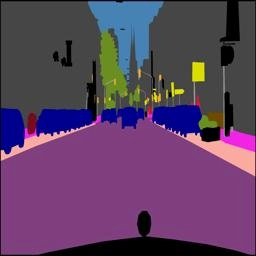

In [60]:
to_pil_image(toRGB(segs[0]))

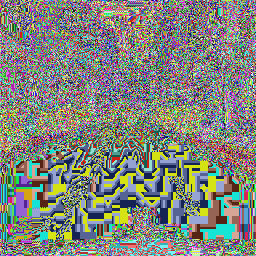

In [58]:
to_pil_image(toRGB(imgs1[0]))

In [54]:
imgs[0]

tensor([[[ 53.5000,  67.0000,  64.5000,  ...,  44.5000,  34.0000,  29.5000],
         [ 62.0000,  85.0000,  77.0000,  ...,  36.0000,  37.0000,  22.5000],
         [ 36.0000,  74.5000,  69.5000,  ...,  68.0000,  81.5000,  47.0000],
         ...,
         [ 40.5000,  73.5000,  76.0000,  ..., 131.0000, 124.0000,  94.0000],
         [ 41.0000,  62.0000,  61.5000,  ...,  91.0000,  87.5000,  67.0000],
         [ 25.5000,  35.0000,  30.0000,  ...,  44.0000,  51.0000,  46.0000]],

        [[ 63.5000,  77.0000,  74.5000,  ...,  52.5000,  42.0000,  35.0000],
         [ 74.0000,  95.0000,  87.0000,  ...,  44.5000,  44.5000,  28.5000],
         [ 47.0000,  83.0000,  78.0000,  ...,  78.0000,  90.5000,  54.5000],
         ...,
         [ 36.5000,  64.0000,  65.5000,  ...,  64.0000,  63.0000,  30.0000],
         [ 40.5000,  55.5000,  54.0000,  ...,  50.5000,  51.0000,  28.0000],
         [ 29.0000,  31.5000,  29.0000,  ...,  28.0000,  29.0000,  28.0000]],

        [[ 58.0000,  71.5000,  69.0000,  ...

In [ ]:
batch(iter(loader))